##Д/з по GB handmade

В этом задании будет использоваться датасет boston из sklearn.datasets. Оставьте последние 25% объектов для контроля качества, разделив X и y на X_train, y_train и X_test, y_test.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
X, y = load_boston(return_X_y=True)
print(X.shape)

(506, 13)


In [11]:
# splitting dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=20)

##Задание №1

Как вы уже знаете из лекций, бустинг - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом.

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь L - квадрат отклонения ответа композиции a(x) от правильного ответа y на данном x.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

$$Производная$$
$$f'(x) = 2(a(x) - y)$$

##Задание №2

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке X:

\[sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью mean_squared_error в sklearn.metrics. Возведите результат в степень 0.5, чтобы получить RMSE. Полученное значение RMSE — ответ в пункте 2.

In [43]:
class GBhandmade:

  def fit(self, X, y, n_estimators=50, eta=[0.9]*n_estimators, model_params=None):
    # make one learning object
    tr_rgs = DecisionTreeRegressor(max_depth=5, random_state=42) if model_params == None \
                                   else DecisionTreeRegressor(**model_params)

    # create base_algorithms & coefficients lists 
    self.base_algorithms_list = [tr_rgs.fit(X, y)]
    self.coefficients_list = eta

    # learning GB algoritm
    for i in range(n_estimators-1):
      # building a basic algorithm DecisionTreeRegressor with modified y according to the concept
      # y --> y - a_n(x)
      tr_rgs = DecisionTreeRegressor(max_depth=5, random_state=42) if model_params == None \
                                   else DecisionTreeRegressor(**model_params)

      self.base_algorithms_list.append(
          tr_rgs.fit(X, y - self.gbm_predict(X))
          )

  def gbm_predict(self, X):
    return [
            sum([coeff * algo.predict([x])[0] 
                 for algo, coeff in zip(self.base_algorithms_list, self.coefficients_list)]) for x in X
            ]

In [40]:
gb_model = GBhandmade()
gb_model.fit(X_train, y_train)

In [41]:
pred = mean_squared_error(y_test, gb_model.gbm_predict(X_test))

print(pred)
with open('ans2.txt', 'w') as fout:
  fout.write(str(pred**0.5))

33.30034829691076


##Задание №3

Вас может также беспокоить, что при движении с постоянным шагом вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49). Используйте качество работы алгоритма как ответ в пункте 3

In [73]:
n_estimators = 50
change_eta = [0.9 / (2.0 + i) for i in range(n_estimators)]

gb_model = GBhandmade()
gb_model.fit(X_train, y_train, eta=change_eta, n_estimators=n_estimators)

In [77]:
pred = mean_squared_error(y_test, gb_model.gbm_predict(X_test))

print(pred)
with open('ans3.txt', 'w') as fout:
  fout.write(str(pred**0.5))

16.425607360102468


##Задание №4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке sklearn, так и в сторонней библиотеке XGBoost, которая имеет свой питоновский интерфейс. На практике XGBoost работает заметно лучше GradientBoostingRegressor из sklearn, но для этого задания вы можете использовать любую реализацию. Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет ответ в п.4):

1) С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

2) С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

3) С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться

4) С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

In [50]:
!pip install xgboost

In [66]:
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [ ]:
n_trees = [1] + list(range(10, 200, 5))
scor = make_scorer(mean_squared_error)

xgb_scoring = []
for n_tree in n_trees:
    estimator = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=n_tree, min_child_weight=3)
    score = cross_val_score(estimator, X, y, 
                            scoring = scor, cv = 3)    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

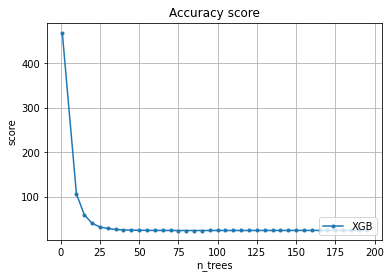

In [80]:
pylab.plot(n_trees, xgb_scoring.mean(axis = 1), marker='.', label='XGB')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

In [ ]:
depth = [i for i in range(2,9)]

xgb_scoring = []
for d in depth:
    estimator = XGBRegressor(learning_rate=0.1, max_depth=d, n_estimators=50, min_child_weight=3)
    score = cross_val_score(estimator, X, y, 
                            scoring = scor, cv = 3)    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

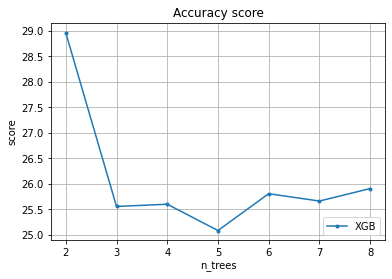

In [71]:
pylab.plot(depth, xgb_scoring.mean(axis = 1), marker='.', label='XGB')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

In [78]:
with open('ans4.txt', 'w') as fout:
  fout.write('2 3')